## Importing necessary libraries

In [1]:
import tensorflow as tf
import numpy as np
import re, os
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [2]:
import tensorflow as tf
import numpy as np
import re, os
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import sklearn
from tqdm import tqdm
import requests
import pandas as pd
import tarfile
import os

#Trining Bert

In [3]:
import requests
import pandas as pd
import tarfile
import os

# Define the URL for the IMDb sentiment analysis dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_filename = "aclImdb_v1.tar.gz"

# Specify the download location
download_location = "./data/"

# Create the download directory if it doesn't exist
if not os.path.exists(download_location):
    os.makedirs(download_location)

# Download the dataset
response = requests.get(url)
with open(download_location + dataset_filename, 'wb') as f:
    f.write(response.content)

# Extract the downloaded file
with tarfile.open(download_location + dataset_filename, 'r:gz') as tar:
    tar.extractall(download_location)

# Define the path to the extracted dataset
dataset_path = download_location + "aclImdb/"

# Function to load the dataset into a Pandas DataFrame
def load_imdb_dataset(data_path):
    texts = []
    labels = []
    for category in ['train', 'test']:
        for sentiment in ['pos', 'neg']:
            folder_path = os.path.join(data_path, category, sentiment)
            for filename in os.listdir(folder_path):
                with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                    text = file.read()
                    texts.append(text)
                    labels.append('positive' if sentiment == 'pos' else 'negative')
    return pd.DataFrame({'review': texts, 'sentiment': labels})

# Load the dataset into a Pandas DataFrame
imdb_df = load_imdb_dataset(dataset_path)

# Display the first few rows of the DataFrame
print(imdb_df.head())
df=imdb_df

                                              review sentiment
0  This game is fun and it has a plot that you co...  positive
1  Red Eye is not the kind of movie that's going ...  positive
2  I am a huge fan of Simon Pegg and have watched...  positive
3  A few summer space campers actually were accid...  positive
4  The perfect space fantasy film. a group of kid...  positive


In [4]:
# Loading the BERT Classifier and Tokenizer along with Input module
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

Bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
Bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
from sklearn.utils import shuffle

# Define the cat2num function
def cat2num(value):
    if value == 'positive':
        return 1
    else:
        return 0

# Shuffle the DataFrame
df_shuffled = shuffle(df,random_state=42)

# Apply the cat2num function to convert 'positive' and 'negative' into numeric values
df_shuffled['sentiment'] = df_shuffled['sentiment'].apply(cat2num)

# Split the shuffled DataFrame into train and test
train = df_shuffled[:25000]
test = df_shuffled[25000:]

In [7]:
print(train['sentiment'].value_counts())


1    12603
0    12397
Name: sentiment, dtype: int64


In [8]:
# But first see BERT tokenizer exmaples and other required stuff!

example='In this Kaggle notebook, I will do sentiment analysis using BERT with Huggingface'
tokens=tokenizer.tokenize(example)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(tokens)
print(token_ids)

['in', 'this', 'ka', '##ggle', 'notebook', ',', 'i', 'will', 'do', 'sentiment', 'analysis', 'using', 'bert', 'with', 'hugging', '##face']
[1999, 2023, 10556, 24679, 14960, 1010, 1045, 2097, 2079, 15792, 4106, 2478, 14324, 2007, 17662, 12172]


In [9]:
def convert_data_to_examples(train, test, review, sentiment):
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[review],
                                                          label = x[sentiment]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[review],
                                                          label = x[sentiment]), axis = 1,)

    return train_InputExamples, validation_InputExamples

train_InputExamples, validation_InputExamples = convert_data_to_examples(train,  test, 'review',  'sentiment')


In [10]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=50):
    features = [] # -> will hold InputFeatures to be converted later

    for e in tqdm(examples):
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,    # Add 'CLS' and 'SEP'
            max_length=max_length,    # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],input_dict["token_type_ids"], input_dict['attention_mask'])
        features.append(InputFeatures( input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label) )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'review'
LABEL_COLUMN = 'sentiment'

In [11]:
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

  0%|          | 0/25000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 25000/25000 [02:16<00:00, 183.07it/s]


In [12]:
# Assuming train_data is a TensorFlow dataset
for input_features, label in train_data.take(11):
    # print("Input IDs:", input_features['input_ids'])
    # print("Attention Mask:", input_features['attention_mask'])
    # print("Token Type IDs:", input_features['token_type_ids'])
    print("Label:", label)


Label: tf.Tensor([0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1], shape=(32,), dtype=int64)
Label: tf.Tensor([0 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0], shape=(32,), dtype=int64)
Label: tf.Tensor([0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0], shape=(32,), dtype=int64)
Label: tf.Tensor([0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0], shape=(32,), dtype=int64)
Label: tf.Tensor([0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0], shape=(32,), dtype=int64)
Label: tf.Tensor([1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0], shape=(32,), dtype=int64)
Label: tf.Tensor([0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1], shape=(32,), dtype=int64)
Label: tf.Tensor([1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1], shape=(32,), dtype=int64)
Label: tf.Tensor([0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1], shape=(32,), dtype=int64)
Label: tf.

In [13]:
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

100%|██████████| 25000/25000 [02:15<00:00, 184.66it/s]


In [14]:
Bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

Bert_model.fit(train_data, epochs=1, validation_data=validation_data)

1564/1564 [==============================] - 711s 422ms/step - loss: 0.3632 - accuracy: 0.8306 - val_loss: 0.4183 - val_accuracy: 0.8178


# Getting data from Kaggle

In [15]:
import requests
import pandas as pd
import tarfile
import os

# Define the URL for the IMDb sentiment analysis dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_filename = "aclImdb_v1.tar.gz"

# Specify the download location
download_location = "./data/"

# Create the download directory if it doesn't exist
if not os.path.exists(download_location):
    os.makedirs(download_location)

# Download the dataset
response = requests.get(url)
with open(download_location + dataset_filename, 'wb') as f:
    f.write(response.content)

# Extract the downloaded file
with tarfile.open(download_location + dataset_filename, 'r:gz') as tar:
    tar.extractall(download_location)

# Define the path to the extracted dataset
dataset_path = download_location + "aclImdb/"

# Function to load the dataset into a Pandas DataFrame
def load_imdb_dataset(data_path):
    texts = []
    labels = []
    for category in ['train', 'test']:
        for sentiment in ['pos', 'neg']:
            folder_path = os.path.join(data_path, category, sentiment)
            for filename in os.listdir(folder_path):
                with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                    text = file.read()
                    texts.append(text)
                    labels.append(1 if sentiment == 'pos' else 0)
    return pd.DataFrame({'text': texts, 'label': labels})

# Load the dataset into a Pandas DataFrame
imdb_df = load_imdb_dataset(dataset_path)

# Display the first few rows of the DataFrame
print(imdb_df.head())


                                                text  label
0  This game is fun and it has a plot that you co...      1
1  Red Eye is not the kind of movie that's going ...      1
2  I am a huge fan of Simon Pegg and have watched...      1
3  A few summer space campers actually were accid...      1
4  The perfect space fantasy film. a group of kid...      1


In [16]:
len(imdb_df)

50000

In [17]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, test, and validation sets
df_train, test_val_df = train_test_split(imdb_df, test_size=20000, random_state=42)
df_test, df_val = train_test_split(test_val_df, test_size=0.2, random_state=42)

# Display the shapes of the resulting DataFrames
print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape)
print("Validation set shape:", df_val.shape)


Train set shape: (30000, 2)
Test set shape: (16000, 2)
Validation set shape: (4000, 2)


In [18]:
df_val.head()

,text,label
26891,"""The Deer Hunter's"" success with critics and p...",1
25024,"This film was amazing, it was extremely funny ...",1
11666,I wasn't born until 4 years after this wonderf...,1
40303,I wrote this as a two part review. Part two ha...,0
18010,The script for this movie was probably found i...,0


In [19]:
df_test.head()

,text,label
24835,My family and I screened Underdog the night be...,0
28073,Really don't care that no one on here likes th...,1
31069,1st watched 8/26/2001 - 8 out of 10 (Dir-John ...,1
25736,Destined to be a classic before it was even co...,1
40229,"A Chicago couple, Dillon and Dougherty, are fa...",0


In [20]:
df_train['label'].value_counts()

0    15084
1    14916
Name: label, dtype: int64

# Preprocessing

In [21]:
# Cleaning/Preprocessing Helper function

def preprocess(s):
  s = re.sub(r'@[a-zA-Z0-9_.]+ ', '', str(s))
  s = re.sub(r'#[a-zA-Z0-9_.]+ ', '', str(s))
  s = re.sub(r'''[^a-zA-Z0-9?. ]+''', '', s)
  s = re.sub(r''''[' ']+''', " ", s)
  s = re.sub(r'(\w)\1{2,}',r'\1',s)
  s = s.lower().strip()
  return s

In [22]:
df_train['text'] = df_train['text'].apply(preprocess)
df_val['text'] = df_val['text'].apply(preprocess)
df_test['text'] = df_test['text'].apply(preprocess)

In [23]:
def get_data(df):
  zeros, ones = df[df['label']==0], df[df['label']==1]
  zero_text, zero_labels = zeros['text'].to_numpy(), zeros['label'].to_numpy()
  one_text, one_labels = ones['text'].to_numpy(), ones['label'].to_numpy()
  X, Y = np.concatenate((one_text,zero_text)), np.concatenate((one_labels,zero_labels))
  return X,Y

In [24]:
X_train,Y_train = get_data(df_train)
X_val,Y_val = get_data(df_val)
X_test,Y_test = get_data(df_test)

In [25]:
X_train.shape,X_val.shape,X_test.shape

((30000,), (4000,), (16000,))

# Creating the Model

In [26]:
# Instantiating the Tokenizer and creating sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer(3000,oov_token=1)
tokenizer.fit_on_texts(X_train)
train_seq = tokenizer.texts_to_sequences(X_train)
val_seq = tokenizer.texts_to_sequences(X_val)
test_seq = tokenizer.texts_to_sequences(X_test)

In [27]:
X_train[0][0:100]

'irrespective of the accuracy of facts bandit queen is a true story its true because the themes it de'

In [28]:
# Padding all sequences
train_seq = tf.keras.preprocessing.sequence.pad_sequences(train_seq,maxlen=50,padding='post')
val_seq = tf.keras.preprocessing.sequence.pad_sequences(val_seq,maxlen=50,padding='post')
test_seq = tf.keras.preprocessing.sequence.pad_sequences(test_seq,maxlen=50,padding='post')

#Creating the Model

In [17]:
# from tensorflow.keras.layers import Embedding,Dense,LSTM,Flatten,Dropout
# def create_model():
#   model = tf.keras.models.Sequential()
#   model.add(Embedding(3000,64))
#   model.add(LSTM(32))
#   model.add(Flatten())
#   model.add(Dense(64,activation='relu'))
#   model.add(Dropout(0.3))
#   model.add(Dense(32,activation='relu'))
#   model.add(Dropout(0.3))
#   model.add(Dense(4,activation='relu'))
#   model.add(Dense(1,activation='sigmoid'))
#   model.summary()
#   model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
#   return model

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Bidirectional, GlobalMaxPooling1D, Dense, Dropout

def create_model():
    model = tf.keras.models.Sequential()
    model.add(Embedding(input_dim=3000, output_dim=128))

    # Convolutional layers
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

    # Global Max Pooling layer
    model.add(GlobalMaxPooling1D())

    # Dense layers
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(units=1, activation='sigmoid'))

    model.summary()

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


# Full Model Training

In [30]:
# HELPER FUNCTION

def plot(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['train_loss','val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['train_accuracy','val_accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

In [31]:
def train_full_model(train_seq,Y_train,val_seq,Y_val,test_seq,Y_test):
  model = create_model()
  history = model.fit(train_seq,Y_train,256,15,validation_data=(val_seq,Y_val),callbacks=[tf.keras.callbacks.ModelCheckpoint('FullModelCheckpoint.h5',save_best_only=True,verbose=1),tf.keras.callbacks.EarlyStopping(patience=6,verbose=1)])
  plot(history)
  model = tf.keras.models.load_model('FullModelCheckpoint.h5')
  print(model.evaluate(test_seq,Y_test))
  return model

# Active Learning

In [32]:
# HELPER FUNCTIONS

def append_history(losses,val_losses,acc,val_acc,history):
  losses = losses + history.history['loss']
  val_losses = val_losses + history.history['val_loss']
  acc = acc + history.history['accuracy']
  val_acc = val_acc + history.history['val_accuracy']
  return losses,val_losses,acc,val_acc

def plot_merged_metrics(losses,val_losses,accuracies,val_accuracies):
  plt.plot(losses)
  plt.plot(val_losses)
  plt.legend(['train_loss','val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(accuracies)
  plt.plot(val_accuracies)
  plt.legend(['train_accuracy','val_accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

In [41]:
tokenizer2 = BertTokenizer.from_pretrained("bert-base-uncased")
# Batch size for efficient processing
batch_size = 32

# Number of batches
num_batches = len(X_train) // batch_size + (len(X_train) % batch_size > 0)

probs = []

for i in range(0, len(X_train), batch_size):
    batch_texts = list(X_train[i:i+batch_size])

    if isinstance(batch_texts, str):
        batch_texts = [batch_texts]

    # Tokenize batch of texts
    tf_batch = tokenizer2(batch_texts, max_length=128, padding=True, truncation=True, return_tensors='tf')

    # Get predictions for the batch
    tf_outputs = Bert_model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1).numpy()

    # Get confidence for each example in the batch
    batch_confidences = np.max(tf_predictions, axis=-1)

    # Append batch confidences to the overall list
    probs.extend(batch_confidences)

    if (i >5000) and (i <5040):
        print(i)

probs = np.array(probs)  # Convert the list to a numpy array if needed


5024


In [42]:
len(probs)

30000

In [43]:
import numpy as np
import tensorflow as tf
import collections

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def sampling(model, pool_features, pool_labels, sampling_size=2000):
    selected_labels = pool_labels[:sampling_size]
    selected_samples = pool_features[:sampling_size]

    return selected_samples, selected_labels



def train_small_models(train_features, train_labels, pool_features, pool_labels, val_seq, Y_val, test_seq, Y_test, iters=3, sampling_size=2000):

    losses, val_losses, accuracies, val_accuracies = [], [], [], []

    for iter_n in range(iters):
        # Create a new model for each iteration
        model = create_model()
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        checkpoint = tf.keras.callbacks.ModelCheckpoint(f'Checkpoint_{iter_n}.h5', save_best_only=True, verbose=1)

        print(f"Starting to train with {train_features.shape[0]} labeled samples")

        history = model.fit(train_features, train_labels, batch_size=256, epochs=15,
                            validation_data=(val_seq, Y_val),
                            callbacks=[checkpoint],
                            shuffle=True)  # Ensure training data shuffling for randomness

        losses, val_losses, accuracies, val_accuracies = append_history(losses, val_losses, accuracies, val_accuracies, history)

        # Evaluate and print accuracy on test data
        test_accuracy = model.evaluate(test_seq, Y_test)[1]
        print(f"Accuracy on test data after iteration {iter_n}: {test_accuracy}, Number of labeled samples: {train_features.shape[0]}")

        # Use uncertainty sampling to select samples from the pool
        selected_samples, selected_labels = sampling(model, pool_features, pool_labels, sampling_size)

        # Remove the chosen samples from the pool
        pool_features = np.delete(pool_features, selected_samples, axis=0)
        pool_labels = np.delete(pool_labels, selected_samples)

        # Add the sampled entries to the original data
        train_features = np.vstack((train_features, selected_samples))
        train_labels = np.hstack((train_labels, selected_labels))

    plot_merged_metrics(losses, val_losses, accuracies, val_accuracies)

    return model


# Ensembling

In [44]:
import numpy as np

# Assuming train_seq and Y_train are your input data and labels
total_data_size = len(train_seq)
split_index = 29000


# Select the first 29000 indices for pool
pool_features = train_seq[0:split_index]
pool_labels = Y_train[0:split_index]

# Select the rest for training
train_features = train_seq[split_index:]
train_labels = Y_train[split_index:]


In [52]:
import numpy as np

# Assuming pool_features is a 2D numpy array and score is a list
# pool_features = np.array([[ 128,    1,  151,  580,   31,  386,    3,    2,    1,   14,   21,
#            2,  102,    1, 1889, 1951,    2,    1,    3,    2,    1,    5,
#            2,    1,   11,   83,   22,  118,   44,   12,   18,    7,  163,
#            6,   27,    1,   19,    9,  100,  411,   11,  228,  245,   13,
#           10,   78,   77,  167,  896,    1],
#        [   7,   17,   23,   44,   23,  121,  427,  390,    1,    1,   12,
#           18,    7,   17,   23,  263,   44,   23,  185,   84,    2,    1,
#         2535,  141,   41,  730,   13,   11,  116,   22,   77,    6,   64,
#           12,   18,   21,    2,  193,  277,   41,   52,    1,    6,   77,
#           54,  198,  193,  277, 1392, 2035]], dtype=np.int32)

# scores = [0.2, 0.1]
score=probs[:29000][::-1]
# Get the indices that would sort the score list
sorted_indices = np.argsort(score)

# Sort the score list and rearrange pool_features array based on the sorted indices
sorted_score = [score[i] for i in sorted_indices]
pool_features = pool_features[sorted_indices]
pool_labels =pool_labels[sorted_indices]
# Now, sorted_score contains the sorted scores, and sorted_pool_features contains
# the corresponding rows from the pool_features array, sorted based on the score
# print(sorted_score)
# print(sorted_pool_features)


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 128)         384000    
                                                                 
 conv1d_19 (Conv1D)          (None, None, 128)         49280     
                                                                 
 max_pooling1d_19 (MaxPooli  (None, None, 128)         0         
 ng1D)                                                           
                                                                 
 bidirectional_19 (Bidirect  (None, None, 128)         98816     
 ional)                                                          
                                                                 
 global_max_pooling1d_19 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                     

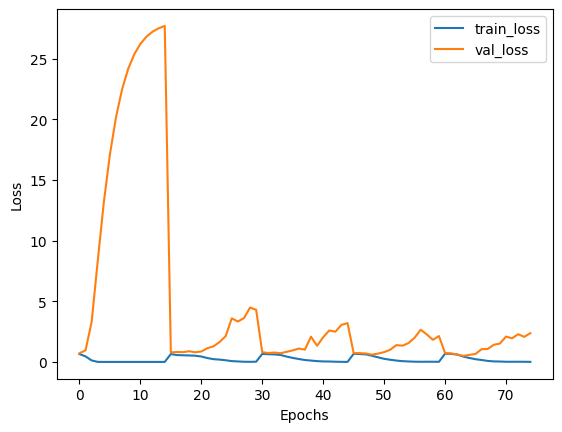

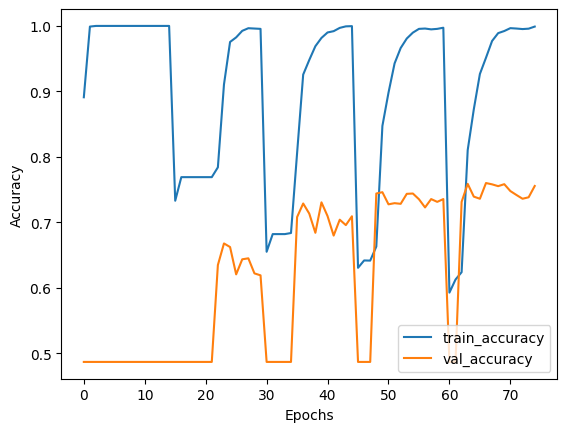

In [55]:
# Training 3 Active Learning Models for Ensembling
al_model1 = train_small_models(train_features,train_labels,pool_features,pool_labels,val_seq,Y_val,test_seq,Y_test,iters=5, sampling_size=1000)
# al_model2 = train_small_models(train_features,train_labels,pool_features,pool_labels,val_seq,Y_val,test_seq,Y_test)
# al_model3 = train_small_models(train_features,train_labels,pool_features,pool_labels,val_seq,Y_val,test_seq,Y_test)

# Predictions

In [ ]:
# Ensembling by taking elementwise average

# pred = (model1.predict(test_seq)+model2.predict(test_seq)+model3.predict(test_seq))/3
al_pred = al_model1.predict(test_seq)

500/500 [==============================] - 7s 15ms/step


In [ ]:
al_pred = np.where(al_pred<0.5,0,1)
print(al_pred[:5])

[[0]
 [1]
 [0]
 [1]
 [1]]


In [ ]:
from sklearn.metrics import accuracy_score
# print(accuracy_score(pred,Y_test))
print(accuracy_score(al_pred,Y_test))

0.7305625
